In [1]:
from sklearn import datasets, linear_model,preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from file_reader import read_file

In [2]:
class MultiClassLogisticRegression:

    def __init__(self, X, y, random_seed=10):
        np.random.seed(random_seed)
        self.loss = []
        self.classes = np.unique(y)
        self.class_labels = {c: i for i, c in enumerate(self.classes)}
        self.weight = np.random.rand(len(self.classes), X.shape[1])
        self.Ti = self.one_hot_encoding(y)

    def one_hot_encoding(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def predict(self, X, weight):
        z = np.dot(X, weight.T)
        return self.softmax(z)

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)  # Numerical stability
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, probs, weight, n, lam):
        epsilon = 1e-8 # Small epsilon value to prevent numerical instability
        clipped_probs = np.clip(probs, epsilon, 1 - epsilon)  # Clip probabilities to avoid extreme 
        l2 = lam * np.sum(np.square(weight)) 
  
        return -(np.sum(self.Ti * np.log(clipped_probs))) / n  + l2         # return -(np.sum(self.Ti * np.log(probs))) / n

    def cross_entropy_loss_gradient(self, X, probs, weight, n, lam):
        return -(np.dot(X.T, (self.Ti - probs))).T / n + lam * weight 
    
    def predict_classes(self, X):
        probs = self.predict(X, self.weight)
        return np.vectorize(lambda c: self.classes[c] )(np.argmax(probs, axis=1)) 
    
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    def armijo_line_search(self, X, gradient, direction, current_loss, alpha, rho, c, lam):

        while alpha > 1e-8:
            new_weight = self.weight + alpha * direction
            probs = self.predict(X, new_weight)
            new_loss = self.cross_entropy_loss(probs, new_weight, len(X), lam)
            armijo_condition = new_loss <= current_loss + c * alpha * np.sum(gradient * direction)
            if armijo_condition:
                break
            else:
                alpha *= rho
                
        return alpha

    def gradient_descend(self, X, max_epoch, alpha, rho, c, lam):
        N = len(X)

        for i in range(max_epoch):
            probs = self.predict(X, self.weight)
            loss = self.cross_entropy_loss(probs, self.weight, N, lam)
            gradient = self.cross_entropy_loss_gradient(X, probs, self.weight, N, lam*2)
            direction = -gradient
            lr = self.armijo_line_search(X, gradient, direction, loss, alpha, rho, c, lam)
            self.weight = self.weight + lr * direction
            self.loss.append(loss)

        

In [3]:
def plot(model):
    plt.xscale('log')
    plt.plot(np.arange(len(model.loss)), model.loss)
    plt.title("Development of loss during Training")
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.show()

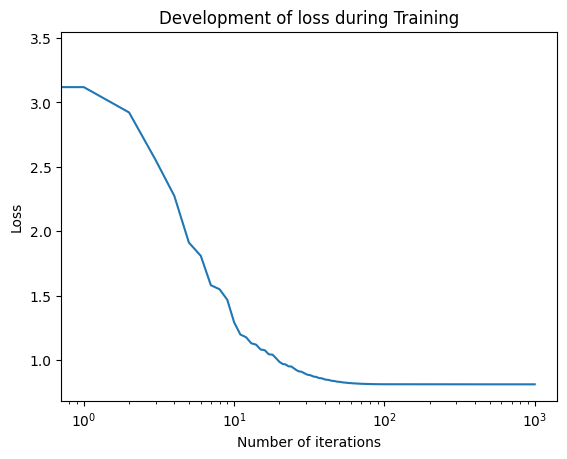

In [4]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.8
ARMIJO_ALPHA = 0.5
ARMIJO_C = 0.01
LAMBDA = 1/4

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

lr = MultiClassLogisticRegression(X_train, y_train)
lr.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

plot(lr)


In [5]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH )
sklearn_lg.fit(X_train, y_train)

print(lr.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.7428571428571429 0.9619047619047619


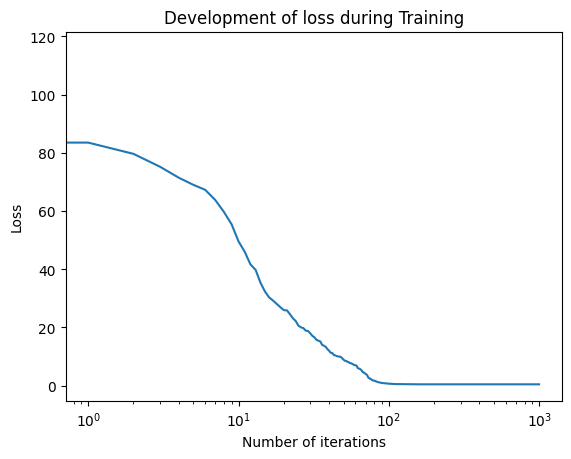

In [6]:
MAX_EPOCH = 1000
ARMIJO_RHO = 0.9
ARMIJO_ALPHA = 0.5
ARMIJO_C = 1e-4
LAMBDA = 1/2

X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
lr = MultiClassLogisticRegression(X_train, y_train)
lr.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

plot(lr)

In [7]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = 10000 )
sklearn_lg.fit(X_train, y_train)

print(lr.score(X_test, y_test), sklearn_lg.score(X_test, y_test))


0.9483306836248012 0.9459459459459459


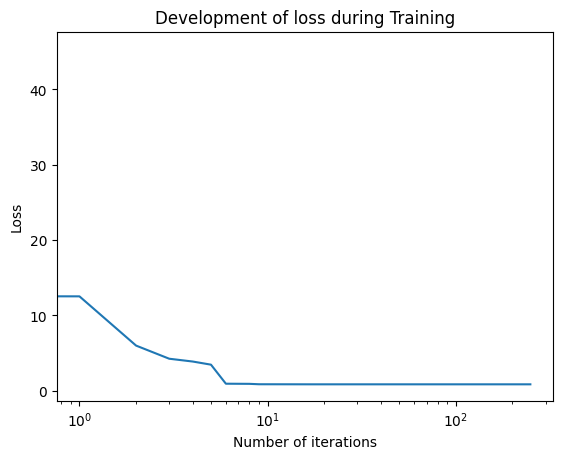

In [8]:
MAX_EPOCH = 250
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 1
ARMIJO_C = 1e-4
LAMBDA = 1/4
X_train, y_train = read_file('datasets/dna/dna_train.txt', 180)
X_test , y_test = read_file('datasets/dna/dna_test.txt', 180)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


lr = MultiClassLogisticRegression(X_train, y_train)
lr.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

plot(lr)

In [9]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)

print(lr.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.7883642495784149 0.9418212478920742


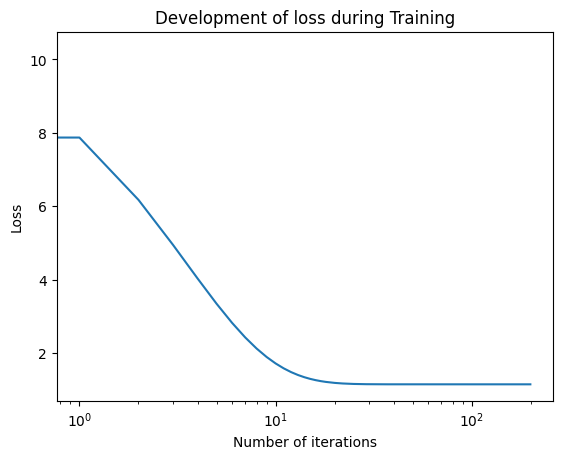

In [10]:
X_train, y_train = read_file('datasets/segment/segment_train.txt', 36)
X_test , y_test = read_file('datasets/segment/segment_test.txt', 36)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

MAX_EPOCH = 200
ARMIJO_RHO = 0.9
ARMIJO_ALPHA = 0.5
ARMIJO_C = 1e-4
LAMBDA = 1/8

lr = MultiClassLogisticRegression(X_train, y_train)
lr.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

plot(lr)

In [11]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter = MAX_EPOCH)
sklearn_lg.fit(X_train, y_train)
print(lr.score(X_test, y_test), sklearn_lg.score(X_test, y_test))

0.689332766680833 0.7879303017424565
